# Import Packages and Data

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.sql.functions import explode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# instantiate SparkSession object
spark = SparkSession\
        .builder\
        .appName("ALSExample").config("spark.driver.host","localhost")\
        .getOrCreate()

In [3]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('../data/test_data/ratings.csv', header='true', inferSchema = 'true')


In [4]:
movie_ratings = movie_ratings.drop('timestamp')


# Grid Search Optimal Hyperparameters with Cross Validation

In [5]:
als_model =  ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
               
params = ParamGridBuilder().addGrid(als_model.regParam, [0.15]).addGrid(als_model.rank, [42]).build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
## instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

In [6]:
predictions = best_model.transform(movie_ratings)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.6332373424454332


In [7]:
rank = best_model.bestModel.rank
rank

42

In [8]:
best_model.getEstimatorParamMaps()

[{Param(parent='ALS_a620940100cc', name='regParam', doc='regularization parameter (>= 0).'): 0.15,
  Param(parent='ALS_a620940100cc', name='rank', doc='rank of the factorization'): 42}]

In [9]:
best_model.avgMetrics

[0.8849426563608307]

# Run Model with full data using parameters from grid search

In [10]:
user_factors = best_model.bestModel.userFactors
recommendationsDF = (user_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

In [11]:
rec_pdf = recommendationsDF.toPandas()
rec_pdf.head()

,id,features
0,10,0.074343
1,10,-0.419712
2,10,-0.125134
3,10,-0.618376
4,10,0.220149


In [12]:
multiplier = rec_pdf['id'].nunique()
feature_array = np.array(list(range(1,rank+1))*multiplier)
rec_pdf['value'] = feature_array

In [13]:
rec_pdf_unstacked = rec_pdf.pivot(index='id', columns='value', values='features')

In [14]:
rec_pdf_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
id,,,,,,,,,,,,,,,,,,,,,
1,0.649971,-0.276065,0.362831,-0.324000,0.362634,-0.264751,-0.641676,0.126261,-0.294428,0.407153,...,-0.479519,-0.546717,0.173987,0.136360,-0.236009,-0.197883,-0.040390,-0.105427,-0.891104,0.411060
2,0.480122,-0.247288,0.315998,0.000713,0.297455,-0.143324,-0.381191,0.039573,-0.324796,0.430132,...,-0.347398,-0.788994,0.141960,-0.074901,0.042852,0.085212,0.217521,-0.087189,-0.570860,0.131570
3,0.392004,-0.249128,0.146257,0.361530,0.606964,-0.142410,0.336853,0.181831,-0.276263,0.253769,...,-0.528071,-0.152566,-0.016734,-0.573781,-0.486312,0.207068,-0.106359,-0.325845,-0.579835,0.176888
4,0.350510,0.424441,0.435111,-0.387014,0.168210,0.241066,-0.237765,0.109490,-0.143090,0.604022,...,-0.572393,-0.633725,0.000525,0.511447,-0.342404,-0.123047,-0.273115,-0.087449,-0.602003,0.740415
5,0.336337,-0.003817,0.310420,-0.508204,0.261654,0.044332,-0.489316,0.047549,-0.368743,0.481438,...,-0.404874,-0.377953,0.197118,0.185579,-0.319260,-0.112923,0.129797,-0.106996,-0.738497,0.466808


# Hierarchical Agglomerative Cluster Analysis

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rec_pdf_scaled = scaler.fit_transform(rec_pdf_unstacked)

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


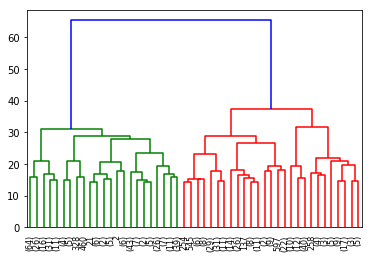

In [230]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline

z = linkage(rec_pdf_scaled, 'ward', metric = 'euclidean') # Ward linkage used to produce tightly knit clusters
c, coph_dist = cophenet(z, pdist(rec_pdf_scaled))
dendrogram(z,
          leaf_rotation=90,
          leaf_font_size = 8.,
          truncate_mode='lastp',
          p=50)
plt.show()

In [231]:
coph_dist.sort()
set(coph_dist)

{1.6931070699193165,
 1.6986865582247301,
 1.9701455742888123,
 2.079417185683468,
 2.2539518407539907,
 2.2648137850157366,
 2.2778409083669606,
 2.327073968092697,
 2.369369123614837,
 2.420798857256764,
 2.4578166092101594,
 2.46209576691377,
 2.4767323411735074,
 2.5026465833459803,
 2.5270573028806904,
 2.592477256705508,
 2.594778621465719,
 2.616410781262716,
 2.6194011546910576,
 2.621517282269956,
 2.6220497209543496,
 2.6353638937658723,
 2.7834322257722515,
 2.8116883036082876,
 2.823821814961436,
 2.8267020720036333,
 2.857537710405793,
 2.875469355783229,
 2.8783810630289954,
 2.892541604342978,
 2.9146772035757507,
 2.9210138181629888,
 2.9249162411269785,
 2.929944593444531,
 2.941930756769769,
 2.9835482234503754,
 2.9944272875553795,
 2.9988568293716336,
 3.0093998602172785,
 3.02054194761374,
 3.0231462704725383,
 3.027363914227176,
 3.0274605862396546,
 3.066683830011607,
 3.087815219753479,
 3.103016655484903,
 3.1042142124780705,
 3.111590454639407,
 3.119380601907

In [232]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
rec_pdf_clustered = pd.DataFrame(rec_pdf_scaled.copy())
cluster = AgglomerativeClustering(n_clusters=9, 
                                 affinity='euclidean',
                                 linkage='ward')
rec_pdf_clustered['cluster'] = cluster.fit_predict(rec_pdf_clustered)

In [233]:
rec_pdf_clustered.groupby(['cluster']).agg(['mean', 'std', 'count'])

0                         1                         2   \
             mean       std count      mean       std count      mean   
cluster                                                                 
0       -0.131407  0.885961   140  0.763769  0.818909   140  0.399751   
1       -0.472782  1.279684    47 -0.272409  1.160821    47 -1.592911   
2        0.041876  0.923289    87 -0.661829  0.796017    87 -0.109624   
3       -0.000901  1.700123    21  0.145520  0.974061    21  0.903368   
4        0.182626  0.827640   148 -0.103371  0.636157   148  0.164503   
5        0.604063  1.641334    11  1.163892  1.364668    11 -0.553456   
6        0.936276  0.956502    34 -1.029006  1.058075    34  0.299777   
7       -0.368102  0.839710    62 -0.047163  0.834328    62 -0.405639   
8       -0.094849  0.746042    60  0.013419  0.896983    60  0.102783   

                               3   ...    38        39                  \
              std count      mean  ... count      mean       std count   
cluster                            ...                                   
0        0.763647   140 -0.024351  ...   140 -0.051765  0.925655   140   
1        1.111130    47 -0.522726  ...    47 -0.469988  0.918653    47   
2        0.837493    87 -0.118959  ...    87 -0.043749  1.089447    87   
3        1.052159    21  1.629892  ...    21  0.655116  1.698931    21   
4        0.641341   148  0.297238  ...   148  0.348204  0.745631   148   
5        1.911413    11  0.720686  ...    11  0.696164  1.549119    11   
6        1.092804    34  0.322732  ...    34 -0.256479  1.194173    34   
7        0.819665    62 -0.678334  ...    62 -0.132748  0.835343    62   
8        0.727435    60 -0.278934  ...    60 -0.380935  0.840516    60   

               40                        41                  
             mean       std count      mean       std count  
cluster                                                      
0       -0.329677  0.813677   140  0.292360  0.882563   140  
1        0.842236  1.271926    47 -0.781928  1.345475    47  
2        0.242417  0.870162    87 -0.437228  0.810067    87  
3       -0.279112  1.064572    21  0.184342  1.292237    21  
4       -0.491021  0.785823   148  0.165807  0.743079   148  
5       -0.661482  1.344206    11 -0.609332  1.527626    11  
6        0.283441  1.081300    34 -0.284286  1.266298    34  
7        0.475492  0.805510    62  0.232908  0.923197    62  
8        0.536180  0.812638    60  0.122942  0.882943    60  

[9 rows x 126 columns]

In [234]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111, projection='3d')
# plt.scatter(rec_pdf_clustered[1], rec_pdf_clustered[5], rec_pdf_clustered[3], c=rec_pdf_clustered.cluster)
# plt.show();

In [235]:
cluster_centroids = rec_pdf_clustered.groupby(['cluster']).agg('mean')

In [236]:
cluster_centroids_array = cluster_centroids.to_numpy()

In [237]:
cluster_distance_matrix = distance_matrix(cluster_centroids_array, cluster_centroids_array, p=2)

In [238]:
cluster_distance_df = pd.DataFrame(cluster_distance_matrix)
cluster_distance_df

,0,1,2,3,4,5,6,7,8
0,0.000000,4.848546,5.248790,4.628398,2.589455,6.334199,5.581289,4.717426,4.073784
1,4.848546,0.000000,4.717466,7.752527,4.666610,8.329566,5.219573,4.337922,4.460077
2,5.248790,4.717466,0.000000,6.691198,4.159607,9.402537,4.275224,3.481049,3.159578
3,4.628398,7.752527,6.691198,0.000000,4.685491,7.900732,6.262383,7.356120,5.522311
4,2.589455,4.666610,4.159607,4.685491,0.000000,6.473570,3.851152,4.793175,3.861295
5,6.334199,8.329566,9.402537,7.900732,6.473570,0.000000,8.924716,9.426030,9.122901
6,5.581289,5.219573,4.275224,6.262383,3.851152,8.924716,0.000000,5.784513,4.020721
7,4.717426,4.337922,3.481049,7.356120,4.793175,9.426030,5.784513,0.000000,3.644826
8,4.073784,4.460077,3.159578,5.522311,3.861295,9.122901,4.020721,3.644826,0.000000


In [239]:
def nearest_clusters(cluster, num_nearest_clusters=2):
    sorted_distances = cluster_distance_df[cluster].sort_values(ascending=True)
    return sorted_distances[1:num_nearest_clusters+1].index.values.astype(int)

In [240]:
nearest_clusters(0, 2)

array([4, 8])

# Bootstrap Sample

In [241]:
bs_sample = rec_pdf_clustered.sample(n=5000, replace=True, axis=0, random_state=42)

# KNN Model (for assigning new user to a cluster)

In [242]:
bs_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,cluster
102,0.787366,0.031144,0.339683,0.316752,-0.261041,-0.082073,-0.819624,-0.136624,-0.275319,-0.923502,...,-0.871870,0.484977,0.881992,0.496669,0.655494,-0.168107,-0.318267,-1.147042,-0.621579,2
435,-0.642224,1.196281,-0.888770,-1.402271,-1.065088,-0.049764,-0.033026,0.622097,1.031470,0.007416,...,0.826827,-0.038320,0.061143,-0.769182,-0.870859,1.283280,-0.842923,1.197945,0.112965,7
270,0.795829,0.230468,-0.330373,1.262706,-0.814167,0.618469,0.195621,-0.856790,0.175869,-0.251679,...,1.798352,0.438209,-0.603302,-0.327569,-0.528667,0.677118,-1.278688,-0.364234,-0.282680,0
106,-0.236266,-0.020594,-0.561391,-2.030239,-0.410153,-1.118839,0.064205,0.153645,1.114862,0.416458,...,-0.137834,0.134016,-0.398937,-0.424716,-0.998761,1.471988,-0.391001,0.444275,0.316575,7
71,0.605644,-0.324755,0.291985,-0.001973,0.208368,-0.019523,-0.087709,-0.412533,-0.358324,0.134745,...,0.344559,0.666725,0.013945,0.285256,0.422532,-0.228066,0.375816,-0.596054,0.454939,4


In [243]:
X = bs_sample.iloc[:,:-1]
y = bs_sample.iloc[:,-1]

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [245]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)
accuracy_score(y_test, test_preds), accuracy_score(y_train, train_preds)

(0.9528, 0.9768)

In [246]:
print(confusion_matrix(y_test, test_preds))
print(confusion_matrix(y_train, train_preds))

[[269   0   0   0   9   0   0   3   0]
 [  0 105   0   0   1   0   0   0   0]
 [  0   2 151   0   8   0   0   3   0]
 [  6   0   0  43   0   0   0   0   0]
 [  1   0   4   0 297   0   0   0   0]
 [  0   0   0   0   3  11   0   0   0]
 [  0   0   4   0   1   0  76   0   0]
 [  1   0   1   0   2   0   0 125   0]
 [  4   0   6   0   0   0   0   0 114]]
[[813   0   0   0  15   0   0   3   0]
 [  0 315   0   0   2   0   0   0   0]
 [  0   3 474   0  12   0   0   6   0]
 [  8   0   0 126   0   0   0   0   0]
 [  3   0   3   0 975   0   0   0   0]
 [  0   0   0   0   2  69   0   0   0]
 [  0   0   2   0   5   0 210   0   0]
 [  3   0   1   0   5   0   0 337   0]
 [  9   0   5   0   0   0   0   0 344]]


# Nearest Centroid

In [247]:
from sklearn.neighbors import NearestCentroid
nc = NearestCentroid()
nc.fit(X_train, y_train)
nc_train_preds = nc.predict(X_train)
nc_test_preds = nc.predict(X_test)
accuracy_score(y_test, nc_test_preds), accuracy_score(y_train, nc_train_preds)

(0.7712, 0.7834666666666666)

In [248]:
print(confusion_matrix(y_test, nc_test_preds))
print(confusion_matrix(y_train, nc_train_preds))

[[195   4   1   5  28   4   2  25  17]
 [  2  90   0   0   2   0   0   9   3]
 [  2   1 122   2  12   0   6  10   9]
 [  2   0   0  36   2   0   0   0   9]
 [ 10   2   4   7 255   2   8   1  13]
 [  0   0   0   0   0  14   0   0   0]
 [  0   0   3   4   6   0  64   0   4]
 [  1   0  12   0   7   0   0 102   7]
 [  7   1   5   0   8   0   8   9  86]]
[[607  13   2  17  62  13   5  84  28]
 [  7 266   0   0   8   0  10  20   6]
 [  5   5 396   3  27   0  16  25  18]
 [  7   0   0 114   2   0   0   0  11]
 [ 47   3  14  22 829   9  21   6  30]
 [  0   0   0   0   0  71   0   0   0]
 [  0   0  19   8  26   0 151   0  13]
 [  5  17  31   0  14   0   0 268  11]
 [ 18   5  23   0  36   0  16  24 236]]


# Decision Tree

In [249]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dc = DecisionTreeClassifier(max_depth=8, max_features=8, criterion='gini', min_samples_leaf=9)
dc.fit(X_train, y_train)
dc_train_preds = dc.predict(X_train)
dc_test_preds = dc.predict(X_test)
accuracy_score(y_test, dc_test_preds), accuracy_score(y_train, dc_train_preds)

(0.792, 0.8208)

In [250]:
print(confusion_matrix(y_test, dc_test_preds))
print(confusion_matrix(y_train, dc_train_preds))

[[233   0   0   5  43   0   0   0   0]
 [  4  75   3   0  11   0   3   8   2]
 [  5   4 139   0   7   0   0   4   5]
 [  2   0   0  22  21   1   0   0   3]
 [  2   4  12   0 273   0   1   6   4]
 [  3   1   0   0   5   2   0   0   3]
 [  1   0  10   0  17   0  53   0   0]
 [ 11   2  10   1   1   0   0 104   0]
 [ 18   4   3   0  10   0   0   0  89]]
[[717   0   0   7 105   0   0   0   2]
 [  7 248   6   0  30   0   4  18   4]
 [  7  13 434   0  17   0   0  15   9]
 [ 10   0   0  65  50   4   0   0   5]
 [ 16   9  13   0 921   0   6  10   6]
 [  7   5   6   0  30  21   0   0   2]
 [  9   0  18   0  41   0 149   0   0]
 [ 23   2  41   5   5   0   0 265   5]
 [ 35   5  14   0  42   0   0   4 258]]


# Random Forest

In [251]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
param_grid = {'criterion':['gini', 'entropy'], 
             'max_depth': [15],
             'min_samples_split': [5],
             'n_estimators': [50],
             'max_features': [6]}
gs_forest = GridSearchCV(rf, param_grid, cv=5)
gs_forest.fit(X_train, y_train)
gs_forest.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 6,
 'min_samples_split': 5,
 'n_estimators': 50}

In [252]:
gs_forest_train_preds = gs_forest.predict(X_train)
gs_forest_test_preds = gs_forest.predict(X_test)
accuracy_score(y_test, gs_forest_test_preds), accuracy_score(y_train, gs_forest_train_preds)

(1.0, 1.0)

In [253]:
print(confusion_matrix(y_test, gs_forest_test_preds))
print(confusion_matrix(y_train, gs_forest_train_preds))

[[281   0   0   0   0   0   0   0   0]
 [  0 106   0   0   0   0   0   0   0]
 [  0   0 164   0   0   0   0   0   0]
 [  0   0   0  49   0   0   0   0   0]
 [  0   0   0   0 302   0   0   0   0]
 [  0   0   0   0   0  14   0   0   0]
 [  0   0   0   0   0   0  81   0   0]
 [  0   0   0   0   0   0   0 129   0]
 [  0   0   0   0   0   0   0   0 124]]
[[831   0   0   0   0   0   0   0   0]
 [  0 317   0   0   0   0   0   0   0]
 [  0   0 495   0   0   0   0   0   0]
 [  0   0   0 134   0   0   0   0   0]
 [  0   0   0   0 981   0   0   0   0]
 [  0   0   0   0   0  71   0   0   0]
 [  0   0   0   0   0   0 217   0   0]
 [  0   0   0   0   0   0   0 346   0]
 [  0   0   0   0   0   0   0   0 358]]


# AdaBoost

In [254]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(learning_rate=.4)
ab.fit(X_train, y_train)
ab_train_preds = ab.predict(X_train)
ab_test_preds = ab.predict(X_test)
accuracy_score(y_test, ab_test_preds), accuracy_score(y_train, ab_train_preds)

(0.4312, 0.46373333333333333)

In [255]:
print(confusion_matrix(y_test, ab_test_preds))
print(confusion_matrix(y_train, ab_train_preds))

[[112   0   0   0 167   0   0   0   2]
 [ 21  35   3   0  37   0   0   0  10]
 [  1   0  37   0  77   0   0  14  35]
 [  8   0   0   4  37   0   0   0   0]
 [ 12   4   0   0 276   0   0   0  10]
 [ 13   0   0   0   1   0   0   0   0]
 [  4   3   2   0  62   0   8   0   2]
 [ 23   0   0   0  28   0   0  44  34]
 [ 17   0   5   0  74   0   3   2  23]]
[[362   0   0   0 449   0   0  10  10]
 [ 49 111   6   0 133   0   0   0  18]
 [  7   0 126   0 202   0   0  29 131]
 [ 34   0   0  17  83   0   0   0   0]
 [ 31  14   0   0 917   0   0   0  19]
 [ 60   6   0   0   5   0   0   0   0]
 [  8   7   8   0 155   0  32   0   7]
 [ 57   0   0   0 108   0   0  96  85]
 [ 41   0  14   0 220   0   3   2  78]]


# Gradient Boosting Classifier

In [256]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
param_grid = {'learning_rate':[.15], 
             'max_depth': [5],
             'min_samples_split': [25],
             'n_estimators': [41],
             'max_features': [7]}
gs_gbc = GridSearchCV(gbc, param_grid, cv=5)
gs_gbc.fit(X_train, y_train)
gbc_train_preds = gs_gbc.predict(X_train)
gbc_test_preds = gs_gbc.predict(X_test)
accuracy_score(y_test, gbc_test_preds), accuracy_score(y_train, gbc_train_preds)

(1.0, 1.0)

In [257]:
gs_gbc.best_params_

{'learning_rate': 0.15,
 'max_depth': 5,
 'max_features': 7,
 'min_samples_split': 25,
 'n_estimators': 41}

In [258]:
print(confusion_matrix(y_test, gbc_test_preds))
print(confusion_matrix(y_train, gbc_train_preds))

[[281   0   0   0   0   0   0   0   0]
 [  0 106   0   0   0   0   0   0   0]
 [  0   0 164   0   0   0   0   0   0]
 [  0   0   0  49   0   0   0   0   0]
 [  0   0   0   0 302   0   0   0   0]
 [  0   0   0   0   0  14   0   0   0]
 [  0   0   0   0   0   0  81   0   0]
 [  0   0   0   0   0   0   0 129   0]
 [  0   0   0   0   0   0   0   0 124]]
[[831   0   0   0   0   0   0   0   0]
 [  0 317   0   0   0   0   0   0   0]
 [  0   0 495   0   0   0   0   0   0]
 [  0   0   0 134   0   0   0   0   0]
 [  0   0   0   0 981   0   0   0   0]
 [  0   0   0   0   0  71   0   0   0]
 [  0   0   0   0   0   0 217   0   0]
 [  0   0   0   0   0   0   0 346   0]
 [  0   0   0   0   0   0   0   0 358]]


# Item Feature Extraction

In [259]:
item_factors = best_model.bestModel.itemFactors

In [260]:
item_factors_df = (item_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

In [261]:
item_factors_pdf = item_factors_df.toPandas()
item_factors_pdf.head()

,id,features
0,10,0.396688
1,10,-0.417098
2,10,0.451437
3,10,-0.278206
4,10,0.215262


In [262]:
multiplier_factors = item_factors_pdf['id'].nunique()
factors_feature_array = np.array(list(range(1,rank+1))*multiplier_factors)
item_factors_pdf['value'] = factors_feature_array
item_factors_unstacked = item_factors_pdf.pivot(index='id', columns='value', values='features')
item_factors_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
id,,,,,,,,,,,,,,,,,,,,,
1,0.251701,-0.003764,0.243077,-0.485722,0.242101,-0.083979,-0.449662,0.213873,-0.338775,0.624842,...,-0.388570,-0.457510,0.128453,-0.043814,-0.226532,0.005249,0.065306,-0.132207,-0.621732,0.383167
2,0.338095,-0.226847,0.153502,-0.508134,0.212902,-0.172668,-0.381932,0.127319,-0.239708,0.547684,...,-0.261037,-0.178546,0.127027,-0.072985,-0.187572,-0.009583,0.158866,-0.126722,-0.592509,0.250810
3,0.323640,-0.192497,0.143363,-0.300436,0.302348,-0.296094,-0.310756,0.075237,-0.254703,0.179977,...,-0.272571,-0.423855,0.154321,-0.029445,-0.189029,-0.082045,0.256588,-0.009572,-0.569792,0.174198
4,0.070726,-0.173679,-0.088843,-0.188347,0.202922,-0.125980,-0.367470,-0.089936,0.035152,0.258610,...,0.026321,-0.272817,-0.000163,-0.022811,-0.114899,-0.060488,0.068131,-0.071497,-0.328321,0.145023
5,0.367309,-0.147605,0.098627,-0.394268,0.131041,-0.238639,-0.400447,0.140261,-0.149922,0.402490,...,-0.233341,-0.366659,0.077828,-0.014111,-0.134355,-0.026025,0.054678,-0.107079,-0.393957,0.054956


# Cluster Centroids

In [263]:
cluster_centroids_df = pd.DataFrame(cluster_centroids_array)
cluster_centroids_df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-0.131407,0.763769,0.399751,-0.024351,-0.144926,0.746616,-0.300235,-0.535026,0.176759,-0.427772,...,0.180321,0.162345,0.235463,0.277659,-0.002554,-0.274683,-0.194389,-0.051765,-0.329677,0.292360
1,-0.472782,-0.272409,-1.592911,-0.522726,-0.422520,-0.198023,-0.513409,0.952465,0.589213,-0.061651,...,0.123978,-0.115534,-0.847381,0.052690,0.095377,-1.169599,0.279363,-0.469988,0.842236,-0.781928
2,0.041876,-0.661829,-0.109624,-0.118959,0.294849,-0.848664,0.227268,0.857506,0.108513,0.577606,...,-0.653099,-0.265582,-0.056886,-0.471049,-0.458809,0.433280,0.259229,-0.043749,0.242417,-0.437228
3,-0.000901,0.145520,0.903368,1.629892,0.683347,0.672428,1.129727,-0.372927,-0.839625,-0.920801,...,-0.627660,0.759683,0.760468,-0.402919,-0.287637,0.552184,-0.553440,0.655116,-0.279112,0.184342
4,0.182626,-0.103371,0.164503,0.297238,0.159776,0.229959,-0.014420,-0.395254,-0.556516,-0.241415,...,0.351583,-0.213117,0.181046,0.319982,0.516856,0.348224,-0.136955,0.348204,-0.491021,0.165807


In [264]:
cluster_centroids.shape

(9, 42)

In [265]:
item_factors_unstacked_transposed = item_factors_unstacked.T

In [266]:
centroid_ratings = np.dot(cluster_centroids, item_factors_unstacked_transposed)

In [267]:
centroid_ratings_df = pd.DataFrame(centroid_ratings)
centroid_ratings_df.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,-0.798473,-1.139258,-1.060650,-0.754291,-1.279312,-0.602430,-0.600082,-1.474217,-1.581675,-1.586098,...,-0.624019,-0.534874,-0.713165,-0.713165,-0.624019,-0.713165,-0.624019,-0.624019,-0.624019,-0.114964
1,-0.767319,-0.685533,-1.196548,0.294333,-0.557104,-2.859063,-0.375283,-1.307212,-0.907282,-1.844382,...,-1.911540,-1.638463,-2.184617,-2.184617,-1.911540,-2.184617,-1.911540,-1.911540,-1.911540,-2.287952
2,2.426781,2.787452,2.920319,1.839706,3.051246,1.829996,1.966206,3.753886,3.506245,2.863634,...,1.542645,1.322267,1.763023,1.763023,1.542645,1.763023,1.542645,1.542645,1.542645,0.757181
3,-4.034397,-4.225716,-3.199251,-3.759185,-3.755458,-2.158071,-4.470008,-2.458643,-2.988033,-2.853797,...,-0.892397,-0.764912,-1.019882,-1.019882,-0.892397,-1.019882,-0.892397,-0.892397,-0.892397,-1.483917
4,0.281741,-0.047433,0.324210,0.002873,-0.300772,1.111512,-0.092582,-0.511045,-0.304626,0.434732,...,0.903674,0.774577,1.032770,1.032770,0.903674,1.032770,0.903674,0.903674,0.903674,1.536636
5,-4.174899,-4.288708,-3.047787,-2.842385,-4.390100,-4.329315,-3.628710,-4.982736,-5.861854,-6.125395,...,-1.932041,-1.656035,-2.208047,-2.208047,-1.932041,-2.208047,-1.932041,-1.932041,-1.932041,-0.004406
6,0.678812,0.506245,0.026167,-0.304868,0.296407,1.249283,0.065278,0.691329,0.054856,2.145032,...,1.545873,1.325034,1.766712,1.766712,1.545873,1.766712,1.545873,1.545873,1.545873,1.125603
7,0.562533,1.509327,1.096770,1.729157,1.601194,0.066018,1.806415,1.252717,1.389102,0.773143,...,-0.871714,-0.747184,-0.996245,-0.996245,-0.871714,-0.996245,-0.871714,-0.871714,-0.871714,-1.283260
8,-0.538131,-0.310781,-1.091694,-0.922429,0.035788,-0.977068,-0.602323,0.369065,0.722630,0.028440,...,-0.821155,-0.703847,-0.938463,-0.938463,-0.821155,-0.938463,-0.821155,-0.821155,-0.821155,-1.619431


In [268]:
centroid_ratings_df.columns = item_factors_unstacked.index
centroid_ratings_df.head()

id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,-0.798473,-1.139258,-1.060650,-0.754291,-1.279312,-0.602430,-0.600082,-1.474217,-1.581675,-1.586098,...,-0.624019,-0.534874,-0.713165,-0.713165,-0.624019,-0.713165,-0.624019,-0.624019,-0.624019,-0.114964
1,-0.767319,-0.685533,-1.196548,0.294333,-0.557104,-2.859063,-0.375283,-1.307212,-0.907282,-1.844382,...,-1.911540,-1.638463,-2.184617,-2.184617,-1.911540,-2.184617,-1.911540,-1.911540,-1.911540,-2.287952
2,2.426781,2.787452,2.920319,1.839706,3.051246,1.829996,1.966206,3.753886,3.506245,2.863634,...,1.542645,1.322267,1.763023,1.763023,1.542645,1.763023,1.542645,1.542645,1.542645,0.757181
3,-4.034397,-4.225716,-3.199251,-3.759185,-3.755458,-2.158071,-4.470008,-2.458643,-2.988033,-2.853797,...,-0.892397,-0.764912,-1.019882,-1.019882,-0.892397,-1.019882,-0.892397,-0.892397,-0.892397,-1.483917
4,0.281741,-0.047433,0.324210,0.002873,-0.300772,1.111512,-0.092582,-0.511045,-0.304626,0.434732,...,0.903674,0.774577,1.032770,1.032770,0.903674,1.032770,0.903674,0.903674,0.903674,1.536636


In [269]:
centroid_ratings_T_df = centroid_ratings_df.transpose()
centroid_ratings_T_df.head()

,0,1,2,3,4,5,6,7,8
id,,,,,,,,,
1,-0.798473,-0.767319,2.426781,-4.034397,0.281741,-4.174899,0.678812,0.562533,-0.538131
2,-1.139258,-0.685533,2.787452,-4.225716,-0.047433,-4.288708,0.506245,1.509327,-0.310781
3,-1.060650,-1.196548,2.920319,-3.199251,0.324210,-3.047787,0.026167,1.096770,-1.091694
4,-0.754291,0.294333,1.839706,-3.759185,0.002873,-2.842385,-0.304868,1.729157,-0.922429
5,-1.279312,-0.557104,3.051246,-3.755458,-0.300772,-4.390100,0.296407,1.601194,0.035788


# New User Data

In [270]:
movies_df = pd.read_csv('../data/test_data/movies.csv')
md = movie_ratings.toPandas()
R = md.pivot(index='userId', columns='movieId', values='rating')
mean_ratings = pd.DataFrame(np.mean(R))
mean_ratings = mean_ratings.reset_index()
total_recs = (md['movieId'].value_counts()).reset_index()
total_recs.columns = ['movieId', 'total_recs']
total_recs = total_recs[total_recs['total_recs']>50]
most_rated = pd.merge(total_recs, mean_ratings, how='left', on='movieId')
most_rated_sorted = most_rated.sort_values(by=0, ascending=False)
top_100 = most_rated_sorted[:100]
top_100 = pd.merge(top_100, movies_df, how='left', on='movieId')

In [379]:
#n_movies_to_rate = input('How many movies would you like to rate?')
ranking_list = top_100.sample(n=10, axis=0)
ranking_list
user_ratings = []
for i in list(range(10)):
    title = ranking_list['title']
    movieId = ranking_list['movieId']
    #print(title.iloc[i])
    user_rating = input('Enter a ranking for {} from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.'.format(title.iloc[i]))
    if user_rating=='':
        pass
    else:
        user_ratings.append((movieId.iloc[i], user_rating))
    

Enter a ranking for Indiana Jones and the Last Crusade (1989) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.4
Enter a ranking for Rear Window (1954) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.5
Enter a ranking for Vertigo (1958) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.4
Enter a ranking for Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.4
Enter a ranking for Stand by Me (1986) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.2
Enter a ranking for Young Frankenstein (1974) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.5
Enter a ranking for Office Space (1999) from 1 (lowest) to 5 (highest). If you have not seen the movie, press enter.5
Enter a ranking for Seven (a.k.a. Se7en) (1995) from 1 (lowest) to 5 (highest). If you have not s

In [380]:
user_ratings 

[(1291, '4'),
 (904, '5'),
 (903, '4'),
 (750, '4'),
 (1259, '2'),
 (1278, '5'),
 (2502, '5'),
 (47, '5'),
 (1197, '5')]

## ALS recommendations

In [381]:
rated_movies = [float(x[0]) for x in user_ratings]
rated_item_factor = item_factors_pdf.loc[item_factors_pdf['id'].isin(rated_movies)].pivot(index='id', columns='value', values='features')
M = rated_item_factor.as_matrix()
E = np.identity(rank)
nui = len(rated_movies)
regParam = 0.15
R = np.array([float(x[1]) for x in user_ratings])

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [382]:
A = M.T.dot(M)+regParam*nui*E

In [383]:
V = M.T.dot(R.T)

In [384]:
user_fac = np.linalg.inv(A).dot(V)

In [385]:
user_fac

array([ 0.38918369, -0.14155985,  0.66690267,  0.02753897,  0.37180371,
        0.01795519, -0.37438206, -0.30740243, -0.38420903,  0.31888973,
       -0.36434291, -0.4237872 , -0.24769869, -0.02761865,  0.47367191,
        0.70892029,  0.21412488, -0.14060062, -0.12690202, -0.01677162,
        0.20076231, -0.61478458,  0.46351636,  0.06374543, -0.19218616,
       -0.13862399,  0.0300282 ,  0.10013839, -0.16291286, -0.00683193,
        0.0008951 , -0.0806008 , -0.28752392, -0.60492662,  0.45895534,
        0.18517098, -0.08688896,  0.28203996,  0.23508934, -0.0977315 ,
       -0.84565734,  0.39075186])

In [386]:
user_movie_ratings = user_fac.dot(item_factors_unstacked.T)

In [387]:
user_movie_ratings_df = pd.DataFrame(user_movie_ratings)

In [388]:
user_movie_ratings_df['movieId'] = item_factors_unstacked.T.columns

In [389]:
user_movie_ratings_df.sort_values(0,ascending=False).head(30)

,0,movieId
2520,5.234723,3379
5192,5.043361,8477
4583,5.033457,6818
7934,4.850383,96004
9496,4.801277,171495
5608,4.792741,27156
5567,4.766280,26810
8821,4.761317,132333
3903,4.761317,5490
5832,4.745120,32582


In [390]:
user_top_10 = user_movie_ratings_df.sort_values(0,ascending=False).head(10)

In [391]:
user_top_10 = user_top_10.merge(movies_df, how='left', on='movieId')

In [392]:
user_top_10.drop([0,'movieId', 'genres'], axis=1, inplace=True)

In [393]:
user_top_10

,title
0,On the Beach (1959)
1,"Jetée, La (1962)"
2,Come and See (Idi i smotri) (1985)
3,Dragon Ball Z: The History of Trunks (Doragon ...
4,Cosmos
5,Neon Genesis Evangelion: The End of Evangelion...
6,Bad Boy Bubby (1993)
7,Seve (2014)
8,The Big Bus (1976)
9,"Wild Parrots of Telegraph Hill, The (2003)"


# Predict User's Cluster

In [394]:
user_cluster = gs_gbc.predict(user_fac.reshape(1,-1))[0]

# Augmented Recommendations

In [395]:
def top_rated_movies(cluster):
    sorted_ratings = centroid_ratings_T_df[cluster].sort_values(ascending=False)
    sorted_ratings_df = sorted_ratings.reset_index()
    most_rated_df = pd.merge(most_rated, movies_df, how='left', on='movieId')
    most_rated_df.drop(['total_recs', 0], axis=1, inplace=True)
    top_movies = pd.merge(sorted_ratings_df, most_rated_df, how='inner', left_on='id', right_on='movieId')
    top_movies.columns = ['id', 'rating', 'movieId', 'title', 'genres']
    top_10_movies = top_movies.sort_values(by='rating', ascending=False )[:10]
    return top_10_movies.title

In [396]:
def get_recommendations(user_cluster):
    near_clusters = nearest_clusters(user_cluster)
    recommendation_set = set()
    for index, cluster in enumerate(near_clusters):
        if index==0:
            recs = np.random.choice(top_rated_movies(cluster), size=6, replace=False)
            recommendation_set.update(set(recs))
        if index==1:
            cluster_unique_top_movies = set(top_rated_movies(cluster)).difference(recommendation_set)
            recs = np.random.choice(list(cluster_unique_top_movies), size=4, replace=False)
            recommendation_set.update(recs)
    print(list(recommendation_set))

In [397]:
get_recommendations(user_cluster)

['12 Angry Men (1957)', 'Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002)', '2001: A Space Odyssey (1968)', 'Taxi Driver (1976)', 'North by Northwest (1959)', 'Matrix Revolutions, The (2003)', 'Citizen Kane (1941)', 'Apocalypse Now (1979)', 'Guardians of the Galaxy (2014)', 'Deadpool (2016)']
